## Which model matches the binary fraction?

Here's the idea: as you change the power law index, the fit and total-relative binary fraction changes

It's also thought, in the literature, that there is some cutoff at higher periods, which would also reduce the binary fraction

These are then degenerate, so you can find the region of cutoff-index space to recover the fraction that you want

What we'll do is take the last mass bin (near $0.4M_\odot$), and look at its binarity. This will be comapred to literature values of like $f_b=0.4$.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [19]:
import style

In [ ]:
s_indices = [0,5,7,9,12]
mdwarfs = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
masses = np.array([t["mass_single"] for t in mdwarfs])
mass_lims = np.percentile(masses, percentiles) 
highm_mdwarfs = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(mdwarfs): # we don't need every object, really 
    if row["mass_single"] > mass_lims[-2]:
        df = dict()
        df["soltype_index"] = s_indices.index(row["solution_type"])
        for item in relevant_list:
            working_item = item
            if item == "mass":
                working_item = "mass_single"
            df[item] = float(row[working_item])
        highm_mdwarfs.append(df)
highm_mdwarfs = np.array(highm_mdwarfs)

  0%|          | 0/225536 [00:00<?, ?it/s]

In [3]:
sc_cubes = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_turnover.pkl", "rb"))
target_mass = sc_cubes["meta"]["reference_masses"][-1]
    
sc_cube = {}
sc_cube["data"] = sc_cubes["data"][target_mass]
sc_cube["meta"] = {}
sc_cube["meta"]["shape"] = sc_cubes["meta"]["shape"]
sc_cube["meta"]["lambdas"] = np.array(sc_cubes["meta"]["lambdas"][-1])
sc_cube["meta"]["periods"] = sc_cubes["meta"]["periods"]
sc_cube["meta"]["parallaxes"] = sc_cubes["meta"]["parallaxes"]

In [4]:
model_cube = Sampler.create_model_cube((35,25), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cube, highm_mdwarfs, model_cube=model_cube)
grids = synthsampler.assign_grids(highm_mdwarfs, p_range=(1,8), q_range=(0.05,0.5), scale=3)

  0%|          | 0/22554 [00:00<?, ?it/s]

In [7]:
cuts = np.linspace(4,8,15)
res = np.zeros((len(cuts), 3))
for i, cut in tqdm(enumerate(cuts)):    
    model_cube = Sampler.create_model_cube((35,25), p_model=(4,1.3), q_model=0.5, pcut=cut)
    synthsampler = Sampler.popsampler(sc_cube, highm_mdwarfs, model_cube=model_cube)
    synthsampler.binarity(resolution=1000, grids=grids, catalogue=highm_mdwarfs, scale=2, verbose=False)
    res[i] = synthsampler.fb_estimator()

0it [00:00, ?it/s]

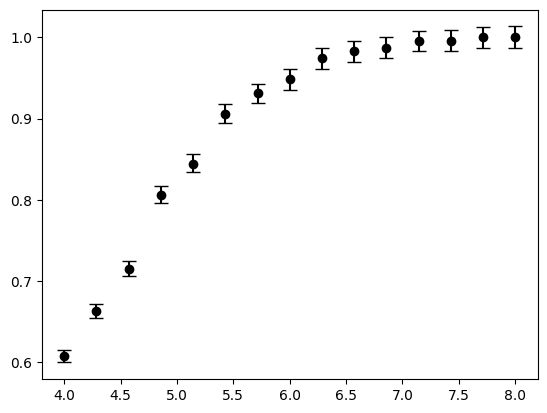

In [11]:
plt.errorbar(cuts, res[:,0]/np.max(res[:,0]), yerr=(res[:,2], res[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(cuts, res[:,0]/np.max(res[:,0]), marker='o', color="k", zorder=2);

In [14]:
cuts = np.linspace(4,7,10)
indices = np.linspace(0,2,10)
res = np.zeros((len(cuts), len(indices), 3))
pbar = tqdm(total=len(cuts)*len(indices))
for i, cut in enumerate(cuts):    
    for j, index in enumerate(indices):
        model_cube = Sampler.create_model_cube((35,25), p_model=(4,1.3), q_model=index, pcut=cut)
        synthsampler = Sampler.popsampler(sc_cube, highm_mdwarfs, model_cube=model_cube)
        synthsampler.binarity(resolution=1000, grids=grids, catalogue=highm_mdwarfs, scale=2, verbose=False)
        res[i,j] = synthsampler.fb_estimator()
        pbar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
def binarity_scaling(index):
    return Sampler.area_in_range_powerlaw((0.05,1), index)/Sampler.area_in_range_powerlaw((0.05,0.5), index)

new_res = np.zeros(res.shape[:-1])
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        scale = binarity_scaling(indices[j])
        new_res[i,j] = Sampler.convert_binarity(res[i,j,0], scale)

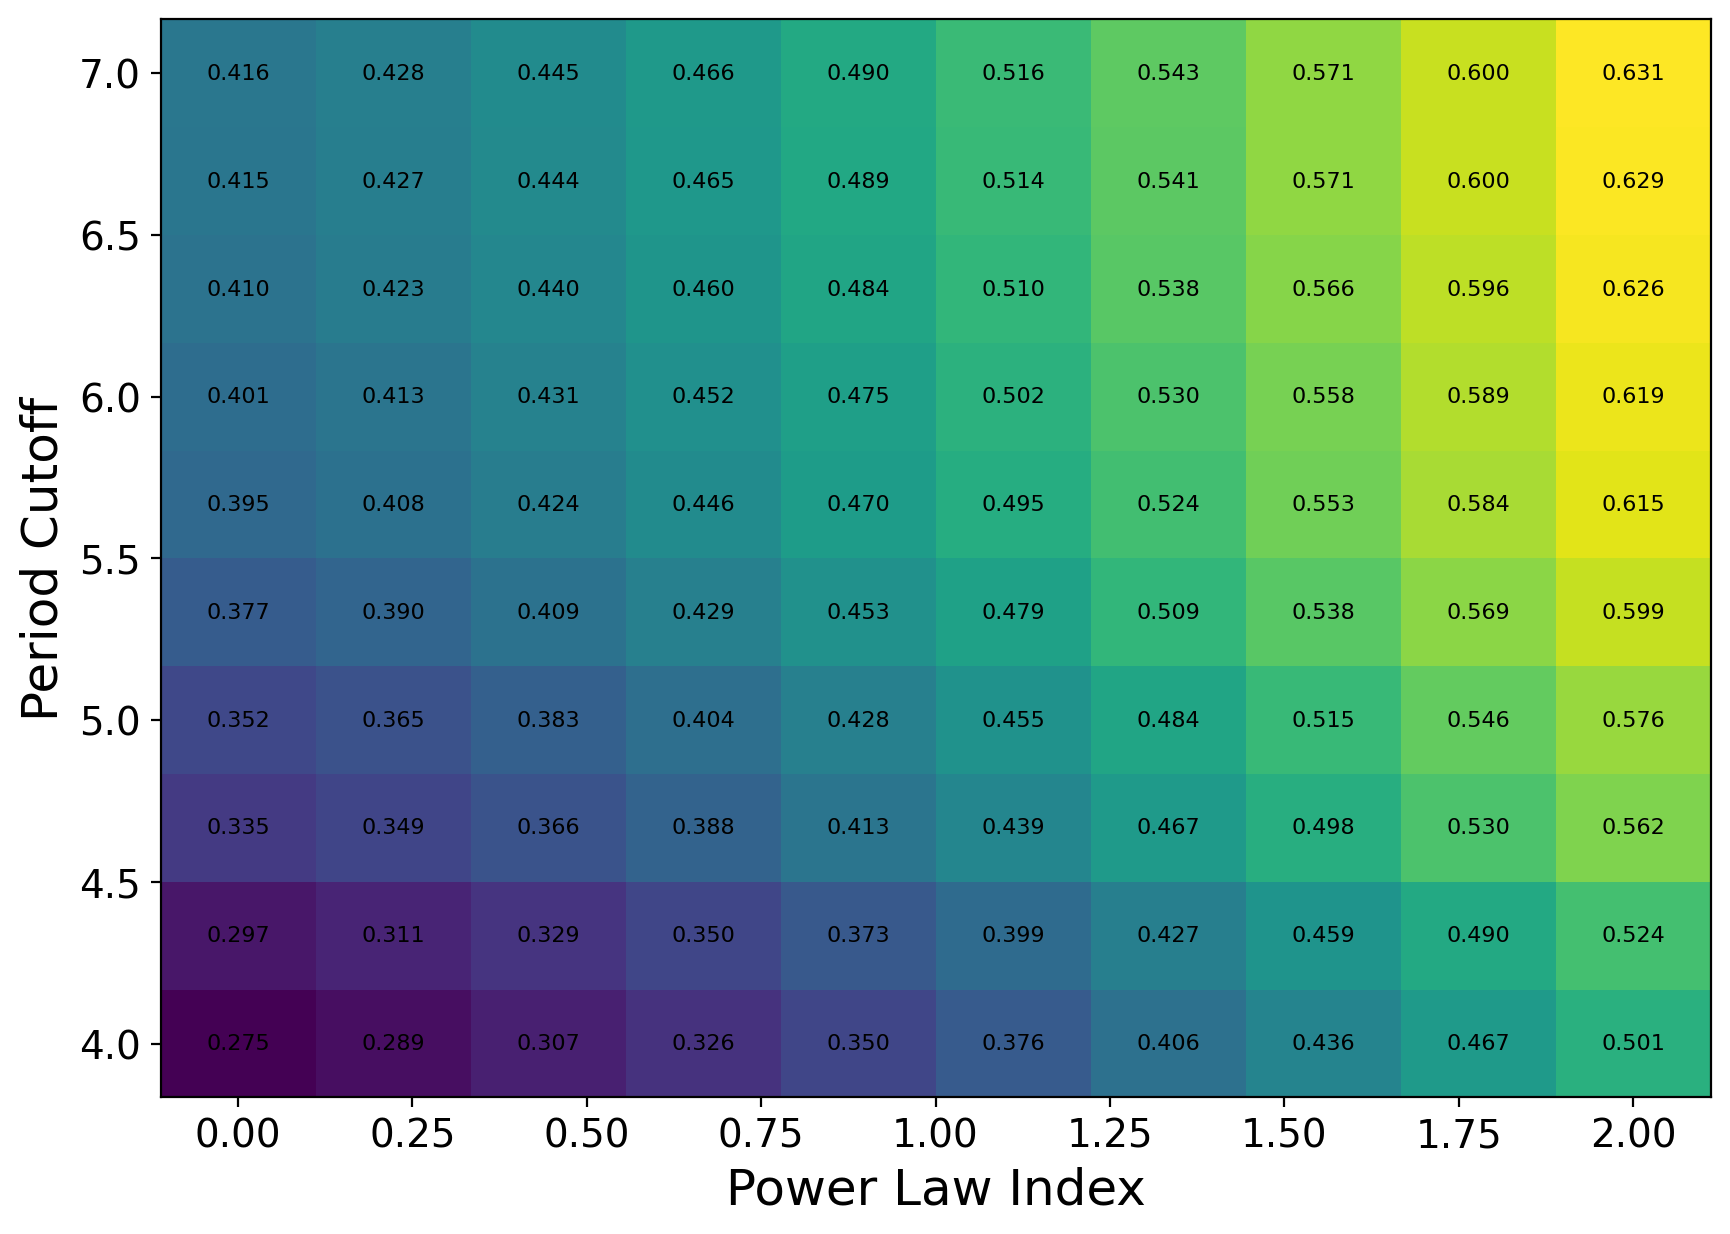

In [58]:
matplotlib.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(10, 7))
mesh = ax.pcolormesh(indices, cuts, new_res)

# Add text to each cell
for i in range(len(cuts)):
    for j in range(len(indices)):
        text = ax.text(indices[j], cuts[i], f'{new_res[i,j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.ylabel('Period Cutoff');
plt.xlabel('Power Law Index');
plt.savefig('./plots/FractionMatching_2D.png', dpi=300)

and the plot without the scaling. The power law has a serious effect here.

In [ ]:
matplotlib.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(10, 7))
mesh = ax.pcolormesh(indices, cuts, res[:,:,0])

# Add text to each cell
for i in range(len(cuts)):
    for j in range(len(indices)):
        text = ax.text(indices[j], cuts[i], f'{res[i,j,0]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.ylabel('Period Cutoff');
plt.xlabel('Power Law Index');

## and on the smallest bin

we should havea 16% binary fraction on the lowest bin, so

In [59]:
0.4/2.5

0.16

In [61]:
s_indices = [0,5,7,9,12]
lowm_mdwarfs = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(mdwarfs): # we don't need every object, really 
    if row["mass_single"] < mass_lims[0]:
        df = dict()
        df["soltype_index"] = s_indices.index(row["solution_type"])
        for item in relevant_list:
            working_item = item
            if item == "mass":
                working_item = "mass_single"
            df[item] = float(row[working_item])
        lowm_mdwarfs.append(df)
lowm_mdwarfs = np.array(lowm_mdwarfs)

  0%|          | 0/225536 [00:00<?, ?it/s]

In [63]:
target_mass = sc_cubes["meta"]["reference_masses"][0]
    
sc_cube_0 = {}
sc_cube_0["data"] = sc_cubes["data"][target_mass]
sc_cube_0["meta"] = {}
sc_cube_0["meta"]["shape"] = sc_cubes["meta"]["shape"]
sc_cube_0["meta"]["lambdas"] = np.array(sc_cubes["meta"]["lambdas"][0])
sc_cube_0["meta"]["periods"] = sc_cubes["meta"]["periods"]
sc_cube_0["meta"]["parallaxes"] = sc_cubes["meta"]["parallaxes"]

In [64]:
model_cube = Sampler.create_model_cube((35,25), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cube_0, lowm_mdwarfs, model_cube=model_cube)
grids_l = synthsampler.assign_grids(lowm_mdwarfs, p_range=(1,8), q_range=(0.05,0.5), scale=3)

  0%|          | 0/22554 [00:00<?, ?it/s]

In [65]:
cuts = np.linspace(3,6,10)
indices = np.linspace(0,2,10)
res_l = np.zeros((len(cuts), len(indices), 3))
pbar = tqdm(total=len(cuts)*len(indices))
for i, cut in enumerate(cuts):    
    for j, index in enumerate(indices):
        model_cube = Sampler.create_model_cube((35,25), p_model=(4,1.3), q_model=index, pcut=cut)
        synthsampler = Sampler.popsampler(sc_cube_0, lowm_mdwarfs, model_cube=model_cube)
        synthsampler.binarity(resolution=1000, grids=grids_l, catalogue=lowm_mdwarfs, scale=2, verbose=False)
        res_l[i,j] = synthsampler.fb_estimator()
        pbar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [66]:
def binarity_scaling(index):
    return Sampler.area_in_range_powerlaw((0.05,1), index)/Sampler.area_in_range_powerlaw((0.05,0.5), index)

new_res_l = np.zeros(res_l.shape[:-1])
for i in range(res_l.shape[0]):
    for j in range(res_l.shape[1]):
        scale = binarity_scaling(indices[j])
        new_res_l[i,j] = Sampler.convert_binarity(res_l[i,j,0], scale)

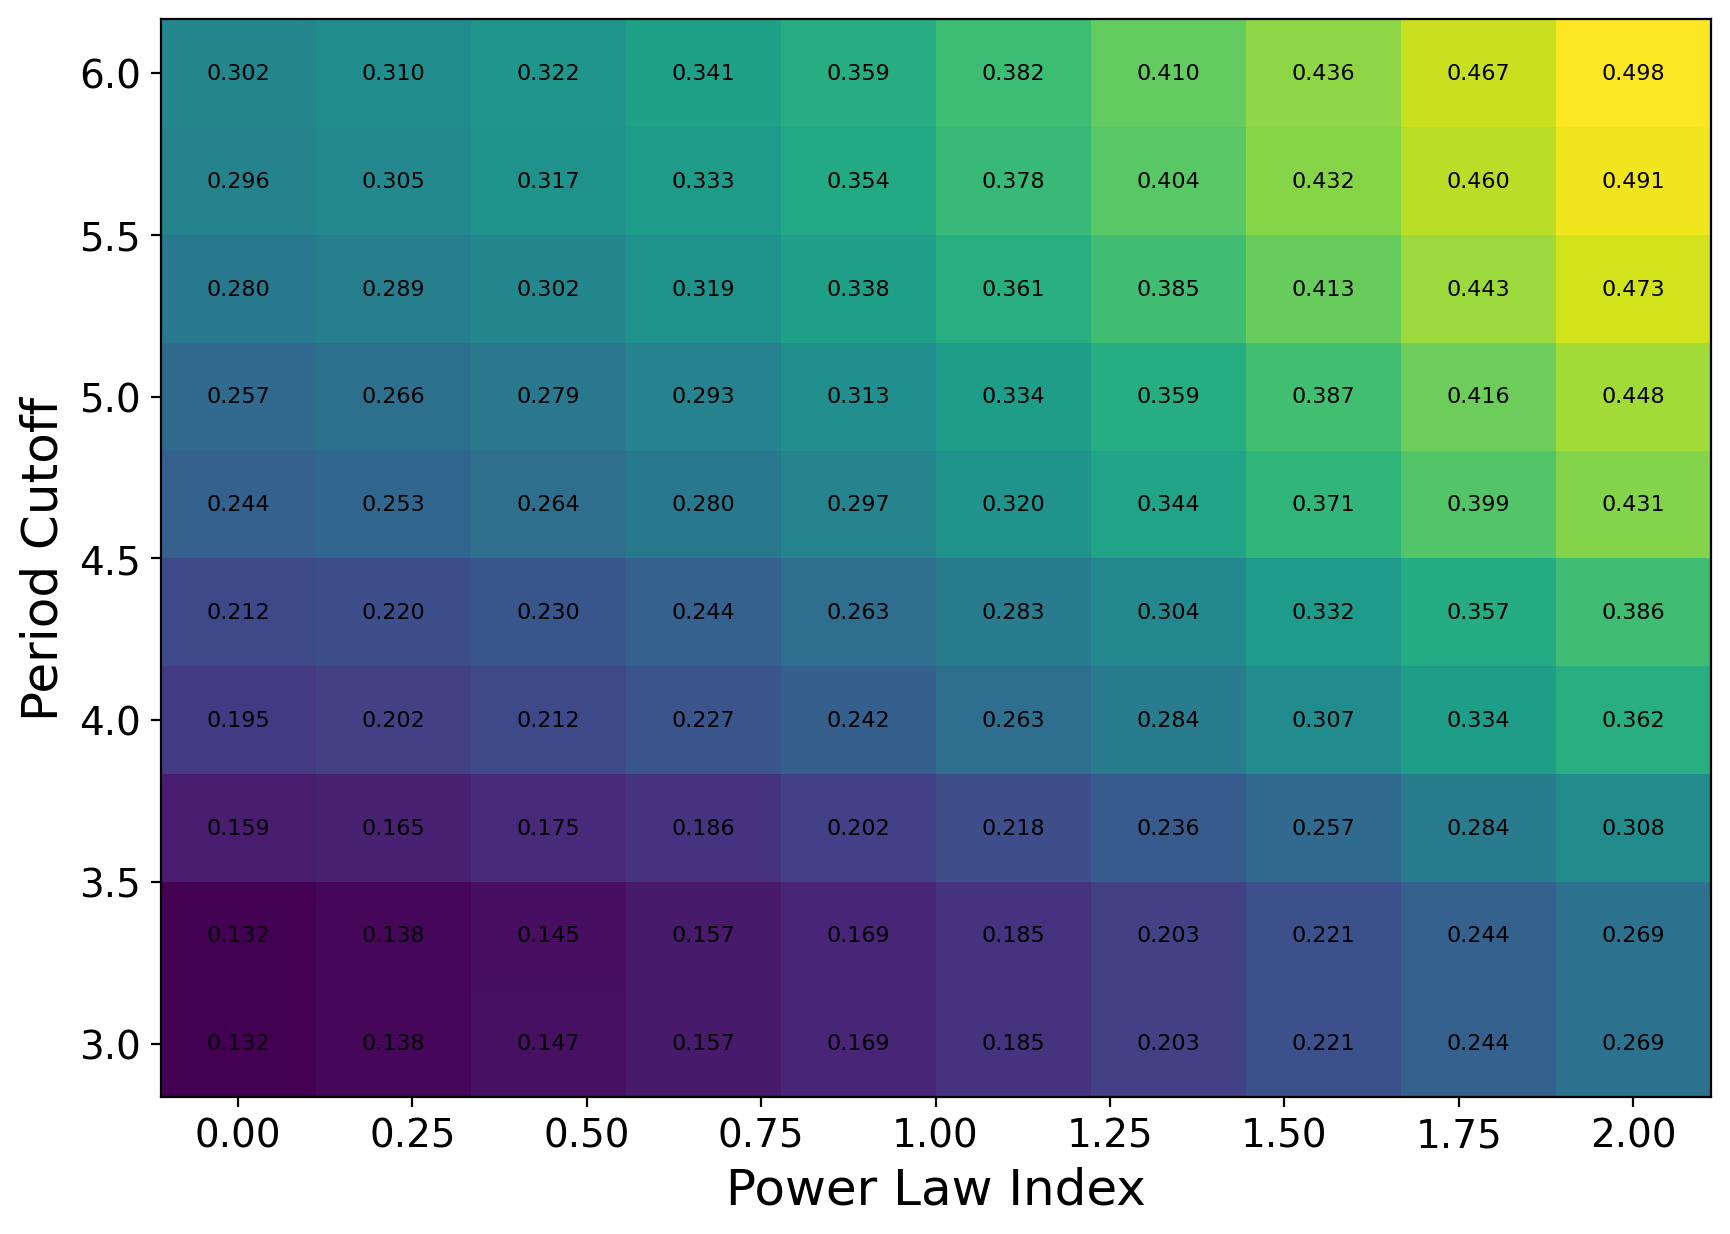

In [67]:
matplotlib.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(10, 7))
mesh = ax.pcolormesh(indices, cuts, new_res_l)

# Add text to each cell
for i in range(len(cuts)):
    for j in range(len(indices)):
        text = ax.text(indices[j], cuts[i], f'{new_res_l[i,j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.ylabel('Period Cutoff');
plt.xlabel('Power Law Index');
#plt.savefig('./plots/FractionMatching_2D.png', dpi=300)

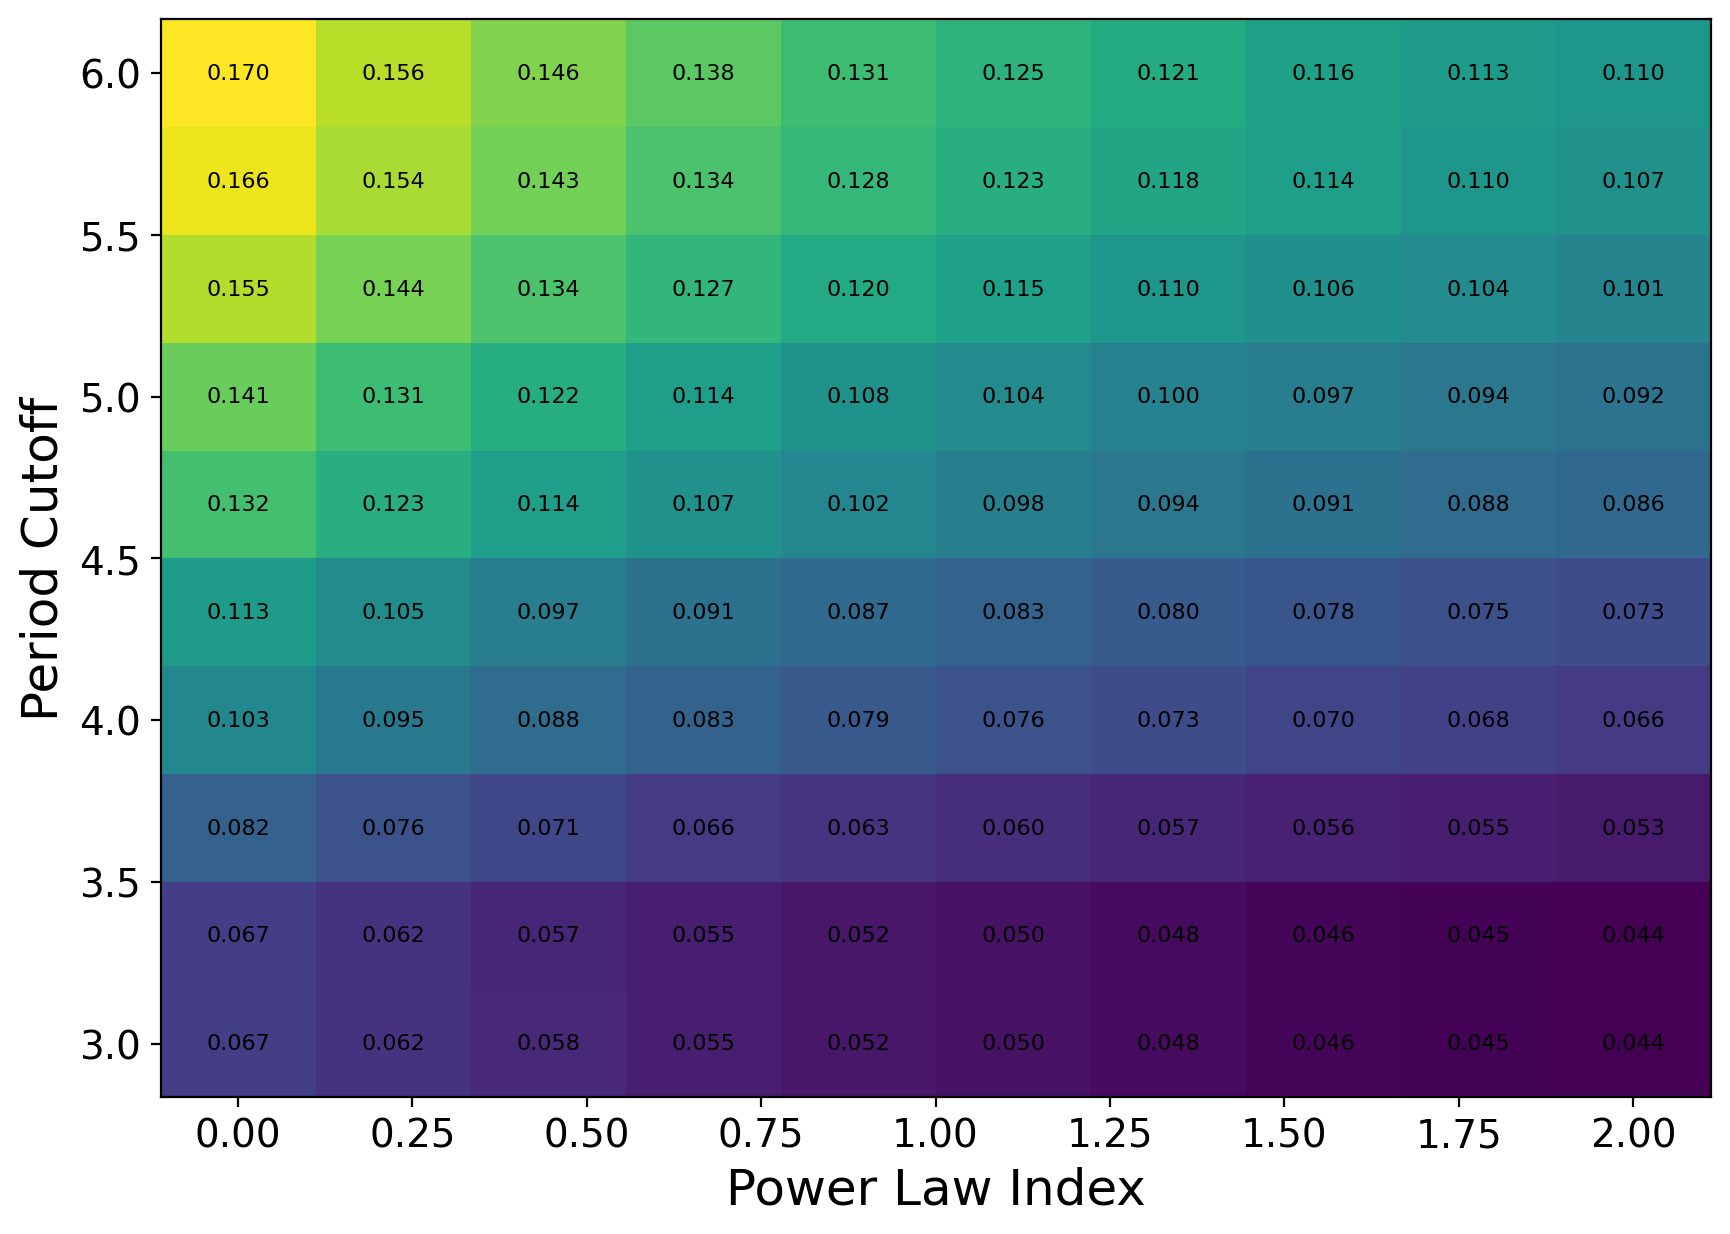

In [69]:
matplotlib.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(10, 7))
mesh = ax.pcolormesh(indices, cuts, res_l[:,:,0])

# Add text to each cell
for i in range(len(cuts)):
    for j in range(len(indices)):
        text = ax.text(indices[j], cuts[i], f'{res_l[i,j,0]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.ylabel('Period Cutoff');
plt.xlabel('Power Law Index');